# Predictor

## Load Classifier

In [1]:
import pickle
import tqdm
import sys

def loadDictFile(dictfile: str, l):    
    with open(dictfile + ".pckl", "rb") as f:
        while True:
            try:
                l.append(pickle.load(f))
            except EOFError:
                break

def loadListFile(file: str, l):    
    with open(file + ".pckl", "rb") as f:
        while True:
            try:
                l.append(pickle.load(f))
            except EOFError:
                break

def writeDictFile(file: str, l):
    with open(file + ".pckl", "wb") as f:
        for val in l.items():
            pickle.dump(val, f)
                

def writeListFile(file: str, l):
    with open(file + ".pckl", "wb") as f:
        for val in l:
            pickle.dump(val, f)


            
raw_model_list = []
raw_stat_list = []
raw_tfidf_list = []

loadDictFile("models/models_tfidf_l1", raw_model_list)
loadDictFile("stats/stats_tfidf_l1", raw_stat_list)
loadDictFile("vects/vectorizers_tfidf_l1", raw_tfidf_list)

In [2]:
from collections import defaultdict

model_dict = defaultdict()
stat_dict = defaultdict()
tfidf_dict = defaultdict()

len_ = len(raw_model_list)
for i in range(len_):
    model_dict[raw_model_list[i][0]] = raw_model_list[i][1]
    stat_dict[raw_stat_list[i][0]] = raw_stat_list[i][1]
    tfidf_dict[raw_tfidf_list[i][0]] = raw_tfidf_list[i][1]

In [3]:
class_list = []
classifier = defaultdict()

for k,v in stat_dict.items():
    if v[2] >= 0.5:
        class_list.append(k)

for cls in class_list:        
    print(cls)
#for class in class_list:
#    print("Dimension[" + cls + "]: ", len(tfidf_list[cls].vocabulary_))


BU-00-00-00-00
CO-00-00-00-00
CR-00-00-00-00
ED-00-00-00-00
ES-00-00-00-00
FA-00-00-00-00
HE-00-00-00-00
HO-00-00-00-00
HO-06-00-00-00
IM-00-00-00-00
MO-00-00-00-00
TO-00-00-00-00
TR-00-00-00-00
TR-01-00-00-00
TR-05-00-00-00
WO-00-00-00-00


## Sample Classification

In [4]:
import numpy as np

text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?"

print(text)

predictions = defaultdict() 
prob = defaultdict()

for cls in class_list:
    text_tfidf = tfidf_dict[cls].transform([text])
    predictions[cls] = model_dict[cls].predict(text_tfidf)
    prob[cls] = model_dict[cls].predict_proba(text_tfidf)[:,1]

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k], 4))

I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?
CR-00-00-00-00 [1.] [1.]
MO-00-00-00-00 [1.] [0.9899]
TO-00-00-00-00 [1.] [0.9765]
TR-00-00-00-00 [1.] [1.]
TR-05-00-00-00 [1.] [0.8779]


## Load JSON

In [5]:
import json


def loadJSON():
    with open("pretty_outfile.json", "r") as f:
        json_object = json.load(f)
    return json_object

json_object = loadJSON()
docs = json_object['data']

print(len(docs))
print()
print(docs[-1])

903050

{'created_utc': 1585518334, 'selftext': "I'm starting a business selling machine-printed posters and tee shirts where the customer uploads an image of themselves to our website, a designer creates a digital drawing of that person and it is then printed and shipped to the person. question is, can i use a drawing that our designers make of a celebrity as an example of the art style? for clarity, this drawing will not be sold and will generate no monetary value directly as it serves no purpose other than showing the art style to people who visit our website. also, can i use the original image to show the contrast between the before and after or not? and what are the restrictions (if any) on who can i use (both as a normal pic and as a drawing)?", 'id': 'frdzlt', 'title': 'Can i use a drawing of a celebrity on my website?'}


## Annual Distribution

In [6]:
import sys
import datetime as dt
import time
from collections import defaultdict
import pandas as pd
import pylab as pl

def utc2ymd(utc: str) -> str:
    #return dt.datetime.utcfromtimestamp(utc).strftime("%Y/%m/%d %H:%M")
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m-%d")

def ymd2utc(ymd: str) -> int:
    utc = dt.datetime.strptime(ymd, '%Y-%m-%d')
    utc = time.mktime(utc.timetuple())
    utc = int(utc)
    return utc


def pretty(d, indent=0):
    print('------------------------------------')
    print('id: ', d['id'])
    ymd = utc2ymd(d['created_utc'])
    print('created_utc:', d['created_utc'], ymd)
    print('title:', d['title'])
    print('selftext:', d['selftext'])
    print('\n')
    print('------------------------------------')
    


utc_dict = {}
num_docs = {}

for year in range(2010, 2021):
    ymd_after = str(year) + '-01-01'
    ymd_before = str(year+1) + '-01-01'
    utc_after = ymd2utc(ymd_after)
    utc_before = ymd2utc(ymd_before)
    utc_dict[year] = (utc_after, utc_before)

print(utc_dict)


for doc in docs:
    
    for k,v in utc_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:
            doc['year'] = k
            if k in num_docs:
                num_docs[int(k)] += 1
            else:
                num_docs[int(k)] = 1
                
cnt = 0
noselftext = 0
for doc in docs:
    if "selftext" in doc:
        cnt+= 1
        pass
    else:
        noselftext += 1
        #print(doc)

print(doc)
        
print('cnt',cnt)
print('noselftext',noselftext)

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


{2010: (1262322000, 1293858000), 2011: (1293858000, 1325394000), 2012: (1325394000, 1357016400), 2013: (1357016400, 1388552400), 2014: (1388552400, 1420088400), 2015: (1420088400, 1451624400), 2016: (1451624400, 1483246800), 2017: (1483246800, 1514782800), 2018: (1514782800, 1546318800), 2019: (1546318800, 1577854800), 2020: (1577854800, 1609477200)}
{'created_utc': 1585518334, 'selftext': "I'm starting a business selling machine-printed posters and tee shirts where the customer uploads an image of themselves to our website, a designer creates a digital drawing of that person and it is then printed and shipped to the person. question is, can i use a drawing that our designers make of a celebrity as an example of the art style? for clarity, this drawing will not be sold and will generate no monetary value directly as it serves no purpose other than showing the art style to people who visit our website. also, can i use the original image to show the contrast between the before and after 

## Plotting

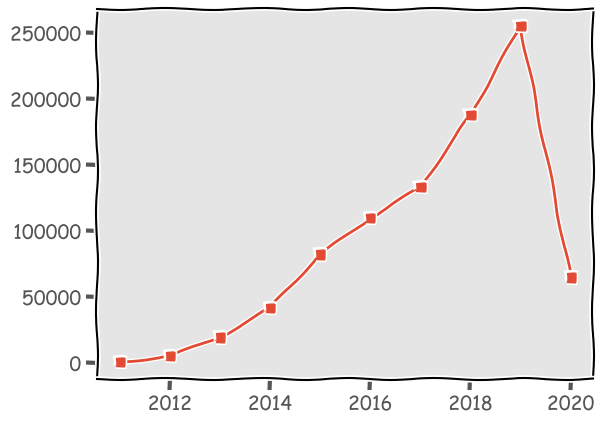

In [55]:
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
matplotlib.style.use("ggplot")
plt.xkcd()
#plt.rcdefaults()
plt.figure()
def plotDict(d: dict, marker:str):
    d.pop(2010, None)
    xdata = []
    ydata = []
    for k,v in d.items():
        xdata.append(k)
        ydata.append(v)
    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)
    
    
    plt.plot(xdata, ydata, marker)
#    plt.annotate(s="Peak", xy=(ydata.argmax(), ydata.max()),\
#                 xytext=(ydata.argmax()+0.5, ydata.max()+0.1),\
#                 arrowprops={"facecolor":"black", "shrink":0.2})
#    plt.ylabel("Number of Submissions")

plotDict(num_docs, "-s")

## Classify (Skip this if hard and soft label available)

In [8]:
import time
from collections import Counter

start_time = time.time()

from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed


def mytransform(cls):
    X_tfidf = tfidf_dict[cls].transform(X)
    return X_tfidf

def generateLabels(cls, X_tfidf):
    hard_v = model_dict[cls].predict(X_tfidf)
    soft_v = model_dict[cls].predict_proba(X_tfidf)[:,1]
    print(len(hard_v))
    print(hard_v)
    print(soft_v)
    return (hard_v, soft_v)

#class_list = ["TR-00-00-00-00"]
X = []
for doc in docs:
    text = ""
    if 'title' in doc.keys():
        text += doc['title']
    if 'selftext' in doc.keys():
        text += doc['selftext']
    X.append(text)

print("Created input test list.")

for cls in tqdm(class_list):
    X_tfidf = mytransform(cls)
    hard_v, soft_v = generateLabels(cls, X_tfidf)
    writeListFile("prevs/" + cls[:5], (hard_v, soft_v))
                                                
print("--- %s seconds ---" % (time.time() - start_time))

Created input test list.


903050
[0. 0. 0. ... 0. 0. 1.]
[0.04285176 0.0051666  0.00294356 ... 0.0051666  0.00478221 0.99963668]
[0. 0. 0. ... 0. 0. 1.]
[0.04285176 0.0051666  0.00294356 ... 0.0051666  0.00478221 0.99963668]
903050
[1. 0. 0. ... 0. 0. 0.]
[0.97572818 0.02031009 0.00494614 ... 0.02031009 0.0235028  0.06119838]
[1. 0. 0. ... 0. 0. 0.]
[0.97572818 0.02031009 0.00494614 ... 0.02031009 0.0235028  0.06119838]
903050
[0. 0. 0. ... 0. 1. 0.]
[0.00356197 0.00697938 0.25233781 ... 0.00375453 0.99793894 0.01200201]
[0. 0. 0. ... 0. 1. 0.]
[0.00356197 0.00697938 0.25233781 ... 0.00375453 0.99793894 0.01200201]
903050
[0. 0. 0. ... 0. 0. 0.]
[0.00433665 0.00433665 0.00433665 ... 0.00433665 0.00433665 0.00433665]
[0. 0. 0. ... 0. 0. 0.]
[0.00433665 0.00433665 0.00433665 ... 0.00433665 0.00433665 0.00433665]
903050
[0. 0. 0. ... 0. 0. 0.]
[0.0030628  0.0030628  0.00895022 ... 0.00052375 0.0030628  0.00345672]
[0. 0. 0. ... 0. 0. 0.]
[0.0030628  0.0030628  0.00895022 ... 0.00052375 0.0030628  0.00345672]
90305

## Load hard and soft labels

In [83]:
def CC(hard_v):
    num_pos = Counter()
    cc = defaultdict() # year-prevalence
    for i in range(len(docs)):
        if hard_v[i] == 1:
            num_pos[docs[i]["year"]] += 1
    for k in num_docs.keys():
        cc[k] = num_pos[k] / num_docs[k]
    return cc


def PCC(soft_v):
    sum_prob = defaultdict()
    pcc = defaultdict() # year-prevalence
    for i in range(len(docs)):
        yr = docs[i]["year"]
        if yr in sum_prob.keys():
            sum_prob[yr] += soft_v[i]
        else:
            sum_prob[yr] = soft_v[i]
    for k in num_docs.keys():
        pcc[k] = sum_prob[k] / num_docs[k]
    return pcc
    
    


hard_dict = defaultdict()
soft_dict = defaultdict()


for cls in tqdm(class_list):
    label_list = []
    loadListFile("prevs/" + cls[:5], label_list)
    hard_dict[cls] = label_list[0]
    soft_dict[cls] = label_list[1]
    
print(hard_dict)


defaultdict(None, {'BU-00-00-00-00': array([0., 0., 0., ..., 0., 0., 1.]), 'CO-00-00-00-00': array([1., 0., 0., ..., 0., 0., 0.]), 'CR-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.]), 'ED-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'ES-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'FA-00-00-00-00': array([0., 0., 0., ..., 1., 0., 0.]), 'HE-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.]), 'HO-00-00-00-00': array([0., 1., 0., ..., 0., 0., 0.]), 'HO-06-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'IM-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'MO-00-00-00-00': array([0., 0., 0., ..., 0., 0., 1.]), 'TO-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-01-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-05-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'WO-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.])})


## Training Labels for Freq-e

In [93]:
from sklearn.model_selection import KFold
import pandas as pd

verbose = False
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))


def predict_train(dfset: defaultdict, cls: str):  
    
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values

    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 

        X_train_tfidf = tfidf_dict[cls].transform(X_train)
        X_test_tfidf = tfidf_dict[cls].transform(X_test)

        out = model_dict[cls].predict(X_test_tfidf)
#        prob = model.predict_proba(X_test_tfidf)[:,1]
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
    return preds

url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)
oldCols = list(df.columns)
newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)        
cols = oldCols[:2] + newCols
df = df[cols]
df.sum(axis=0, skipna=True)


dfset = defaultdict()
label_prior = defaultdict()
y_train = defaultdict()
numdoc = defaultdict()

for cls in tqdm(class_list):
    preprocessing(dfset, cls)
    #y_train[cls] = predict_train(dfset, cls)
    tinydf = dfset[cls]
    y_train[cls] = tinydf[cls].values
    label_prior[cls] = np.mean(y_train[cls])
    print(label_prior[cls])
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


0.05849056603773585
0.09106529209621993
0.17986896962477666
0.013237727523441808
0.040123456790123455
0.17482859941234083
0.06421052631578947
0.2579737335834897
0.02045728038507822
0.018329938900203666
0.2561231630510847
0.18297533810660302
0.1296111665004985
0.0120415982484948
0.017070484581497798
0.19437468608739328



## Freq-e

In [125]:
import freq_e

def FREQ_E(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        yr = docs[i]["year"]
        if yr in bucket.keys():
            bucket[yr].append(soft_dict[i])
        else:
            bucket[yr] = [soft_dict[i]]
            
    for k in num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

## CC, PCC, and Freq-e

[4.50811975e-03 9.13597121e-03 3.77609568e-05 ... 7.67167846e-04
 7.40348898e-03 9.13597121e-03]
0.1296111665004985


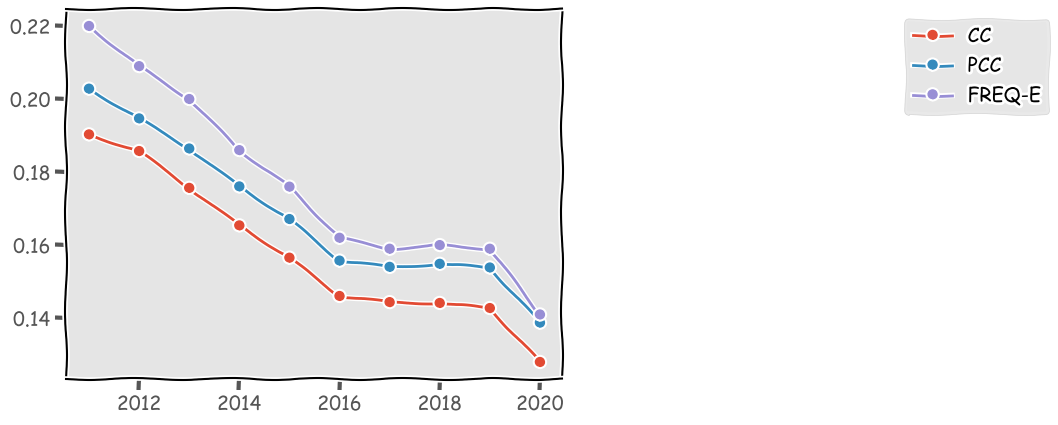

In [136]:
test_cls = "TR-00-00-00-00"
print(soft_dict[test_cls])
print(label_prior[test_cls])


cc = CC(hard_dict[test_cls])
pcc = PCC(soft_dict[test_cls])
freq_e_result = FREQ_E(soft_dict[test_cls], label_prior[test_cls])

plotDict(cc, "-o")
plotDict(pcc, "-o")
plotDict(freq_e_result, "-o")

plt.legend(["CC", "PCC", "FREQ-E"], bbox_to_anchor=(2, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()

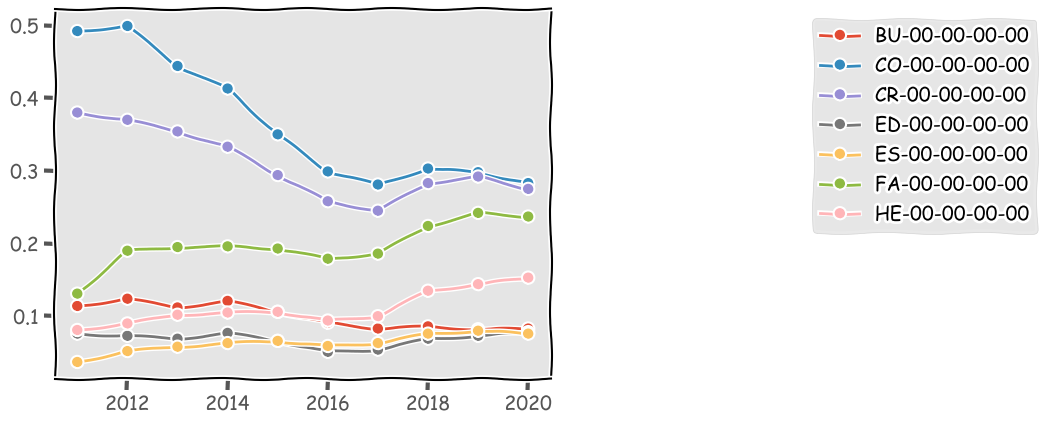

In [129]:
m_list = ["-o", "-s", "-^"]
i = 0
for cls in tqdm(class_list[:7]):
    label_list = []
    loadListFile("prevs/" + cls[:5], label_list)
    hard_dict[cls] = label_list[0]
    soft_dict[cls] = label_list[1]
    #cc = CC(hard_dict[cls])
    result = FREQ_E(soft_dict[cls], label_prior[cls])
    marker = m_list[i//7]
    plotDict(result, marker)
    i += 1

plt.legend(class_list[:7], bbox_to_anchor=(2, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()

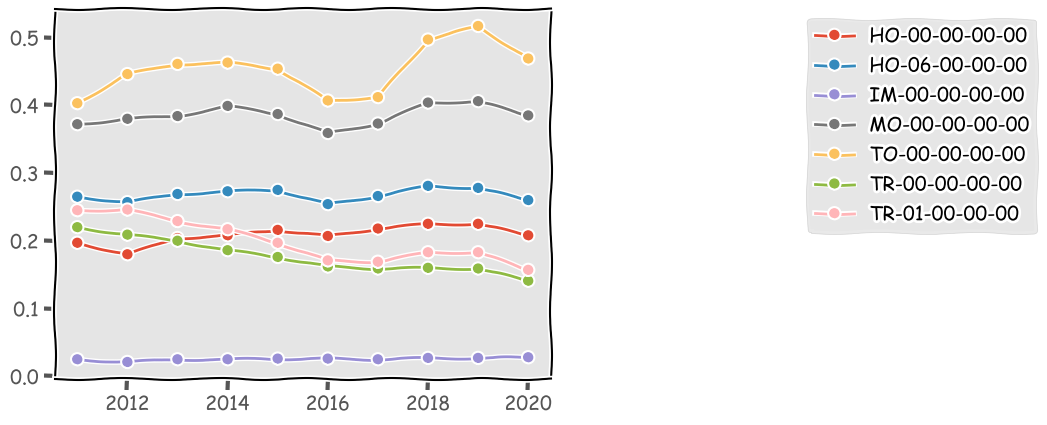

In [130]:
i = 0
for cls in tqdm(class_list[7:14]):
    label_list = []
    loadListFile("prevs/" + cls[:5], label_list)
    hard_dict[cls] = label_list[0]
    soft_dict[cls] = label_list[1]
    result = FREQ_E(soft_dict[cls], label_prior[cls])
    marker = m_list[i//7]
    plotDict(result, marker)
    i += 1

plt.legend(class_list[7:14], bbox_to_anchor=(2, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()

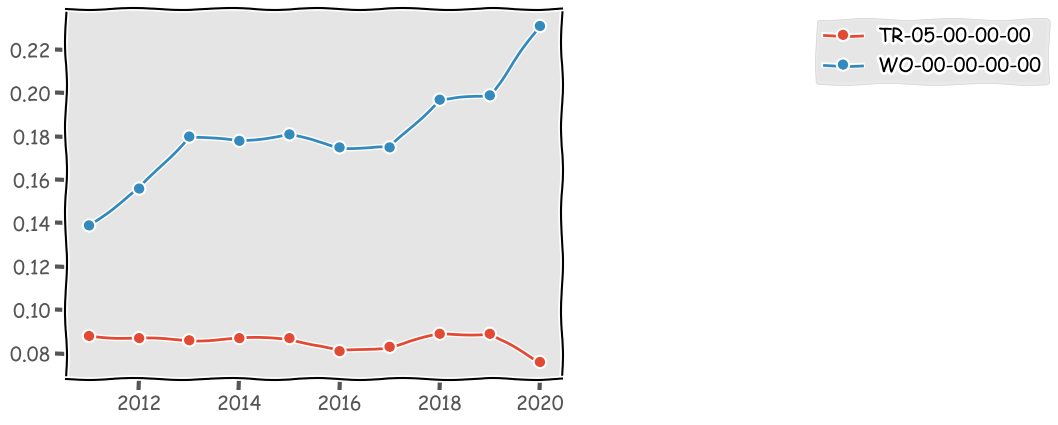

In [131]:
i = 0
for cls in tqdm(class_list[14:16]):
    label_list = []
    loadListFile("prevs/" + cls[:5], label_list)
    hard_dict[cls] = label_list[0]
    soft_dict[cls] = label_list[1]
    result = FREQ_E(soft_dict[cls], label_prior[cls])
    marker = m_list[i//7]
    plotDict(result, marker)
    i += 1

plt.legend(class_list[14:16], bbox_to_anchor=(2, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()